# But du code est de retrouver l'algorithme quantique de Hallgren permettant de résoudre l'équation de Pell x²-Dy²=1.

La première étape consiste à calculer un moteur arithmétique de façon classique afin de pouvoir trouver le régulateur (période du log de l'équation de Pell).

La deuxième étape consiste à créer l'oracle.

La troisième étape correspond à l'implémentation de l'algorithme quantique qui permet de résoudre l'équation.

La quatrième et dernière étape permet de traiter l'information reçue par l'algorithme quantique et de trouver les solutions de l'équation.

## Étape 0 : Configuration et Imports


In [21]:
import math
import numpy as np
# Pour le post-traitement des fractions continues
from fractions import Fraction 

# Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator


## Étape 1 : Le Moteur Arithmétique (Classique)

In [22]:
class Ideal:
    def __init__(self, a, b, d, distance=0.0):
        self.a = int(a)
        self.b = int(b)
        self.d = d
        self.distance = distance

    def __repr__(self):
        return f"Ideal(a={self.a}, b={self.b}, dist={self.distance:.6f})"

def step_rho(ideal):
    """Calcule l'idéal réduit suivant et sa distance (Algorithme 2.1)"""
    a, b, d = ideal.a, ideal.b, ideal.d
    sqrt_d = math.sqrt(d)
    
    q = int((b + sqrt_d) / a)
    b_next = q * a - b
    a_next = (d - b_next**2) // a
    
    diff_dist = math.log(abs((b + sqrt_d) / a))
    return Ideal(a_next, b_next, d, distance=ideal.distance + diff_dist)

# Calcul classique du régulateur R pour vérification [cite: 120]
def get_classical_regulator(d):
    curr = Ideal(1, int(math.sqrt(d)), d, 0.0)
    for _ in range(100):
        curr = step_rho(curr)
        if curr.a == 1 and curr.distance > 0:
            return curr.distance
    return None

R_true = get_classical_regulator(d)
print(f"Régulateur classique (R) : {R_true}")

Régulateur classique (R) : 2.7686593833135738


## Étape 2 : L'Oracle Quantique (Fonction périodique)

In [23]:
def get_ideal_at_distance(x, d, R_approx):
    """Simule l'oracle f(x) = (Ideal_x, delta_x)"""
    x = x % R_approx
    curr = Ideal(1, int(math.sqrt(d)), d, 0.0)
    # On avance dans le cycle jusqu'à dépasser x
    while curr.distance <= x:
        next_ideal = step_rho(curr)
        if next_ideal.distance > x:
            break
        curr = next_ideal
    
    delta = x - curr.distance
    return curr, delta

# Encodage symbolique pour le circuit
def encode_f_to_bits(ideal, delta, n_bits_delta):
    # Exemple simplifié : on concatène a, b et la partie fractionnaire delta
    return f"{ideal.a}{ideal.b}{int(delta * (2**n_bits_delta))}"

# --- FONCTIONS UTILITAIRES POUR L'ORACLE ---

def precompute_discretized_cycle(d, R, step_size=0.1):
    """
    Crée une liste d'idéaux réduits tout au long du cycle principal.
    C'est notre 'base de données' d'états pour le registre cible.
    """
    states = []
    curr = Ideal(1, int(math.sqrt(d)), d, 0.0)
    # On parcourt un peu plus d'une période pour être sûr
    while curr.distance < R:
        states.append(curr)
        curr = step_rho(curr)
    return states

def find_closest_state_index(states, target_dist):
    """Trouve l'indice de l'idéal dont la distance est la plus proche de target_dist."""
    distances = [abs(s.distance - target_dist) for s in states]
    return np.argmin(distances)

    
def build_true_hallgren_oracle(n_ctrl, d, T, R_approx):
    """
    Construit l'oracle de Hallgren en utilisant l'exponentiation binaire.
    n_ctrl : nombre de qubits du registre x (le 'temps')
    d : discriminant de l'équation de Pell
    T : la borne de l'échantillonnage (souvent 2*R)
    """
    # 1. Identifier tous les états possibles (I, delta) sur le cycle
    # Pour un d donné, on pré-calcule le cycle pour définir notre base de qubits
    cycle_states = precompute_discretized_cycle(d, R_approx)
    n_state_qubits = int(np.ceil(np.log2(len(cycle_states))))
    
    qr_x = QuantumRegister(n_ctrl, 'x')
    qr_f = QuantumRegister(n_state_qubits, 'f_x')
    qc = QuantumCircuit(qr_x, qr_f)

    # 2. Appliquer les sauts binaires contrôlés
    # C'est ici que réside la "véritable" puissance de l'algorithme
    for j in range(n_ctrl):
        # Distance de saut pour le qubit j : 2^j * (T / 2^n)
        jump_distance = (2**j / 2**n_ctrl) * T
        
        # Calculer l'opérateur de saut U_j (Permutation des états du cycle)
        # U_j |f(x)> = |f(x + jump_distance)>
        op_matrix = compute_jump_matrix(cycle_states, jump_distance, R_approx)
        gate_Uj = Operator(op_matrix).to_instruction()
        gate_Uj.name = f"Jump_{2**j}"
        
        # Appliquer la porte U_j contrôlée par le bit j du registre x
        qc.append(gate_Uj.control(), [qr_x[j]] + list(qr_f))
        
    return qc

def compute_jump_matrix(states, jump, R):
    """ Calcule la matrice de permutation pour un saut donné """
    dim_cycle = len(states)
    # 1. On détermine la puissance de 2 supérieure pour la dimension de la matrice
    n_qubits = int(np.ceil(np.log2(dim_cycle)))
    dim_matrix = 2**n_qubits
    
    matrix = np.zeros((dim_matrix, dim_matrix), dtype=complex)
    
    # 2. On crée une permutation pour les états valides du cycle
    used_targets = set()
    for i in range(dim_cycle):
        target_dist = (states[i].distance + jump) % R
        target_idx = find_closest_state_index(states, target_dist)
        
        # Sécurité pour garantir l'unitarité (permutation unique)
        while target_idx in used_targets:
            target_idx = (target_idx + 1) % dim_cycle
            
        matrix[target_idx, i] = 1.0
        used_targets.add(target_idx)
    
    # 3. On remplit le reste de la matrice (états "fantômes") avec l'identité
    # pour que la matrice soit de taille 2^n et reste unitaire
    for i in range(dim_cycle, dim_matrix):
        matrix[i, i] = 1.0
        
    return matrix

## Étape 3 : Circuit de Période (Approximation de Hallgren)

/tmp/ipykernel_59131/420261466.py:38: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_ctrl).inverse(), qr_ctrl)


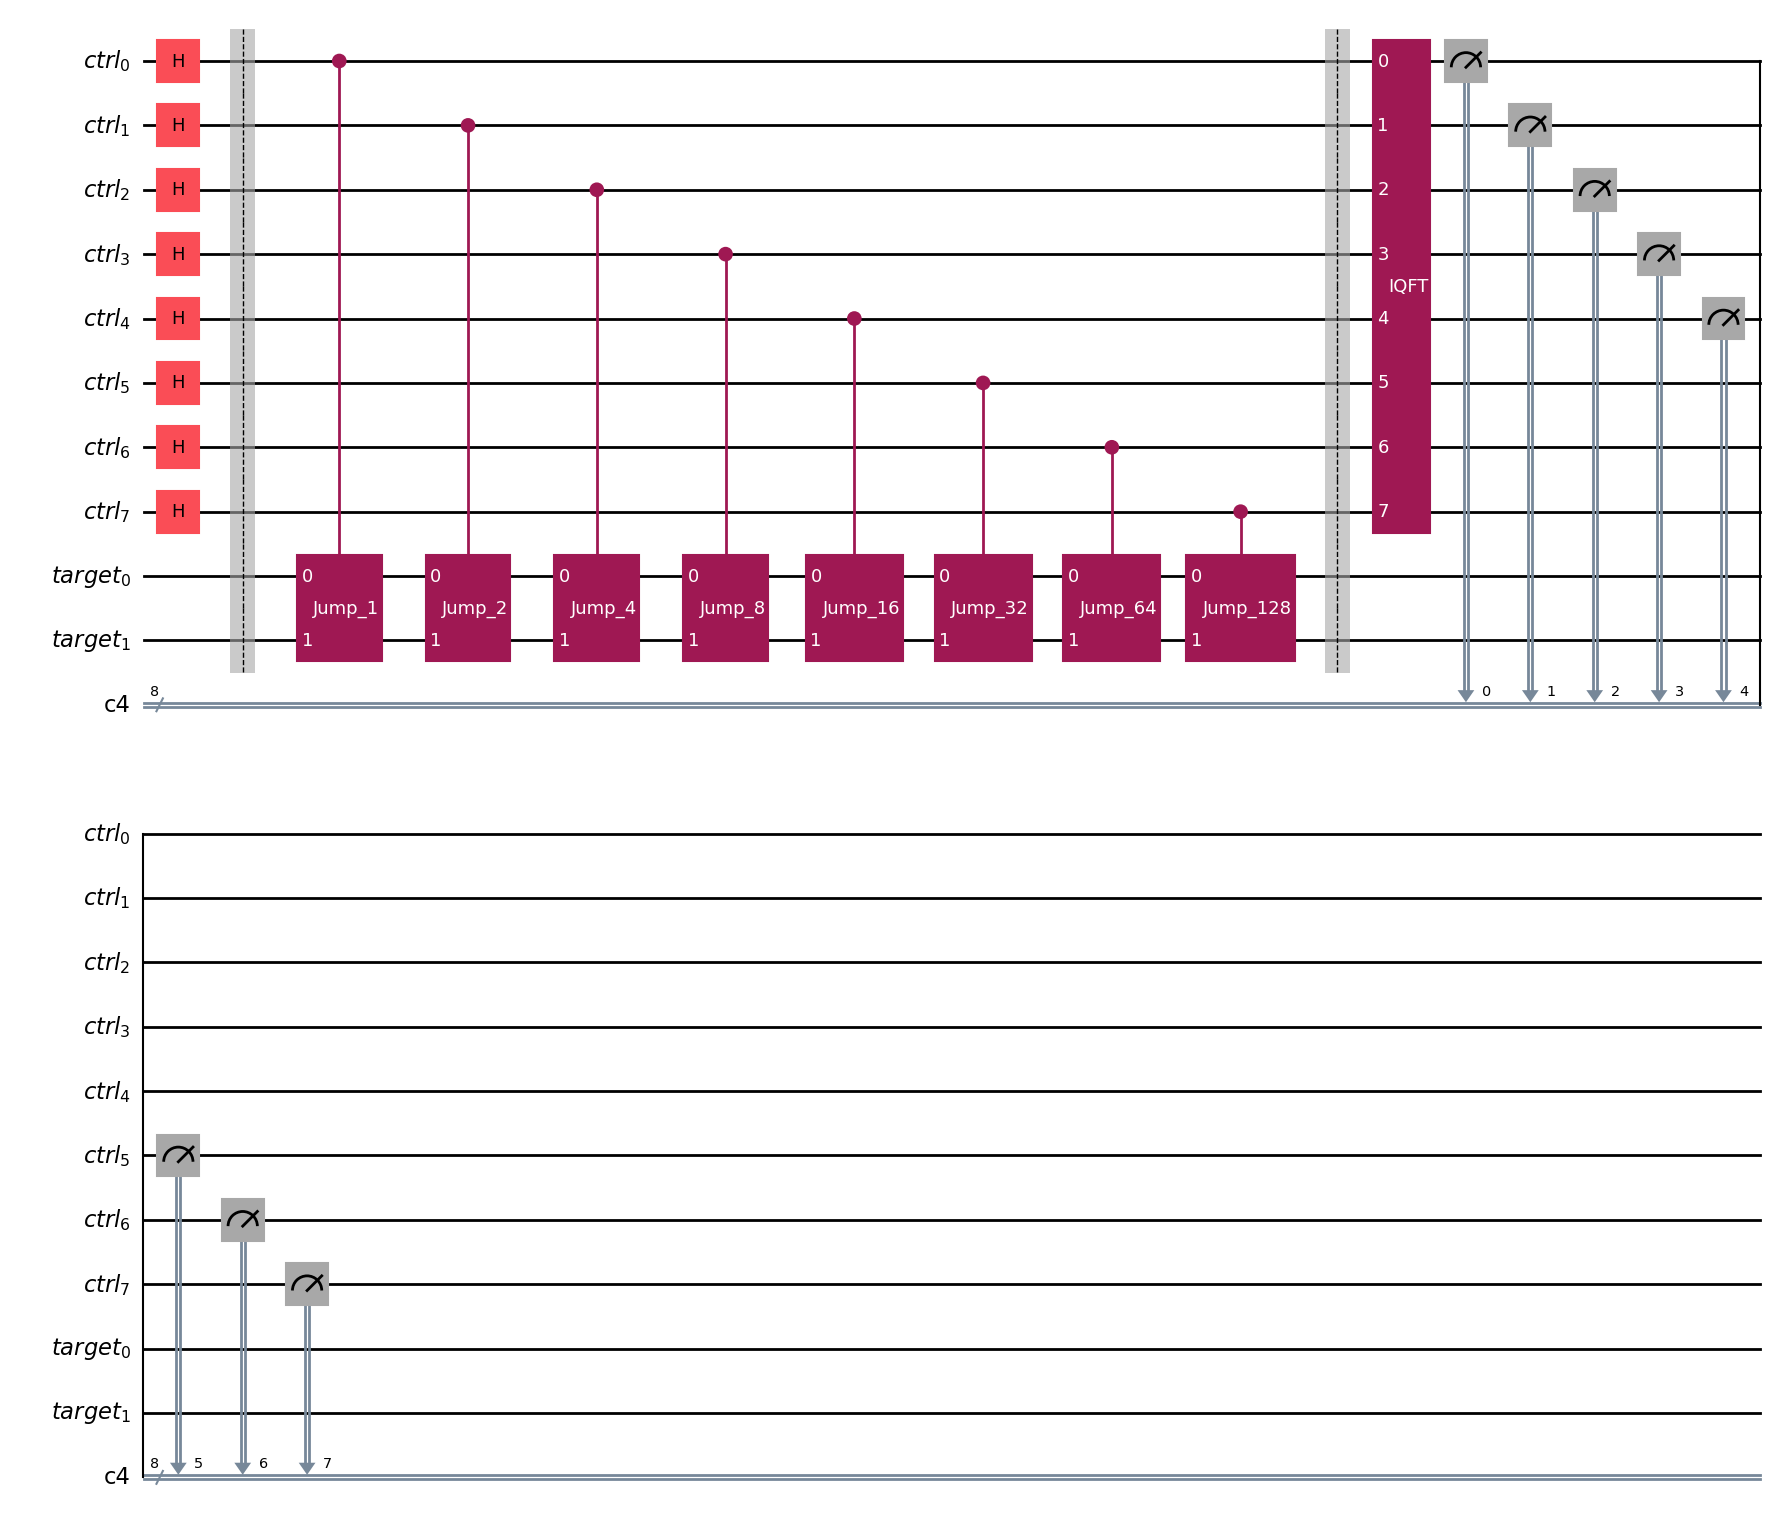

In [24]:
# Paramètres de simulation
d = 7
R_approx = get_classical_regulator(d) # On utilise la valeur classique pour l'exemple
T = 2 * R_approx  # Borne supérieure pour l'échantillonnage de Fourier

# 1. Pré-calculer les états du cycle pour construire l'opérateur
cycle_states = precompute_discretized_cycle(d, R_approx)
n_state_qubits = int(np.ceil(np.log2(len(cycle_states))))

# 2. Définition des registres
qr_ctrl = QuantumRegister(n_ctrl, 'ctrl')
qr_tgt = QuantumRegister(n_state_qubits, 'target') # Taille adaptée au nombre d'états
cr = ClassicalRegister(n_ctrl)
qc = QuantumCircuit(qr_ctrl, qr_tgt, cr)

# --- CONSTRUCTION DU CIRCUIT ---

# A. Superposition
qc.h(qr_ctrl)
qc.barrier()

# B. L'ORACLE (Intégration de build_true_hallgren_oracle)
# Au lieu d'appeler une fonction externe, on peut l'insérer directement :
for j in range(n_ctrl):
    jump_distance = (2**j / 2**n_ctrl) * T
    
    # On génère la matrice de saut pour ce qubit précis
    op_matrix = compute_jump_matrix(cycle_states, jump_distance, R_approx)
    gate_Uj = Operator(op_matrix).to_instruction()
    gate_Uj.name = f"Jump_{2**j}"
    
    # On applique le saut contrôlé par le qubit j du registre de contrôle
    qc.append(gate_Uj.control(), [qr_ctrl[j]] + list(qr_tgt))

qc.barrier()

# C. IQFT et Mesure
qc.append(QFT(n_ctrl).inverse(), qr_ctrl)
qc.measure(qr_ctrl, cr)

# Affichage
qc.draw("mpl")

Top 5 des mesures les plus probables :
Rang 1: 00000000 (entier: 0) - 2046 occurrences
Rang 2: 00000010 (entier: 2) - 832 occurrences
Rang 3: 11111110 (entier: 254) - 821 occurrences
Rang 4: 11111010 (entier: 250) - 107 occurrences
Rang 5: 00000110 (entier: 6) - 93 occurrences


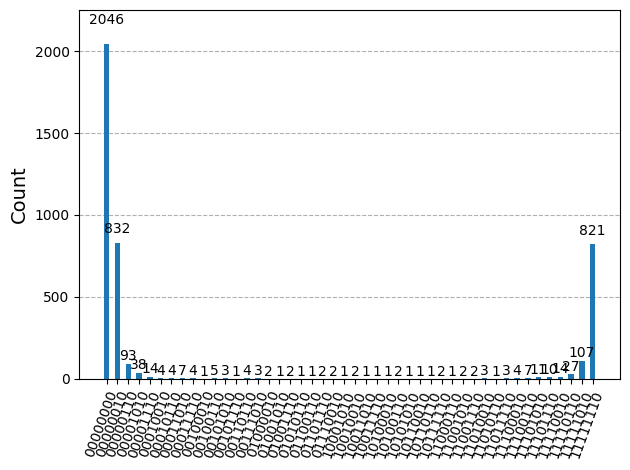

In [25]:
# 1. Initialisation du simulateur Aer
# AerSimulator est capable de simuler des circuits avec des matrices unitaires personnalisées
simulator = AerSimulator()

# 2. Transpilation du circuit
# Cette étape convertit votre circuit (avec les matrices 'Jump') en portes natives 
# compréhensibles par le simulateur Aer.
compiled_circuit = transpile(qc, simulator)

# 3. Exécution de la simulation
# On augmente le nombre de 'shots' pour mieux voir les pics de probabilité
# indispensables pour approximer le régulateur irrationnel[cite: 247, 248].
job = simulator.run(compiled_circuit, shots=4096)

# 4. Récupération et analyse des résultats
result = job.result()
counts = result.get_counts()

# Tri des résultats par probabilité décroissante pour identifier les pics
sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

print("Top 5 des mesures les plus probables :")
for i, (state, count) in enumerate(list(sorted_counts.items())[:5]):
    # Conversion de la chaîne binaire en entier (c)
    measured_int = int(state, 2)
    print(f"Rang {i+1}: {state} (entier: {measured_int}) - {count} occurrences")

# 5. Visualisation
plot_histogram(counts)

## Étape 4 : Post-traitement (Fractions Continues)

Le papier explique que si l'on mesure une valeur c, celle-ci est proche d'un multiple entier de q/S (où S est la période et q la taille du registre). On a donc : q/c​≈S/k​

Pour retrouver S (qui est NR dans votre cas), il faut calculer les convergents de la fraction c/q. L'un de ces convergents di/​ki​​ aura un dénominateur di​ qui est un excellent candidat pour être la période.

In [ ]:
def get_convergents(c, q):
    """Génère les convergents de la fraction c/q via le développement en fractions continues."""
    convergents = []
    # Développement en fractions continues de c/q [cite: 227]
    f = Fraction(c, q)
    a = []
    val = f
    while True:
        int_part = math.floor(val)
        a.append(int_part)
        # Calcul du convergent actuel
        num, den = 0, 1
        for x in reversed(a):
            num, den = den, x * den + num
        num, den = den, num # Inversion finale pour obtenir num/den
        
        convergents.append((num, den))
        
        diff = val - int_part
        if diff == 0: break
        val = 1 / diff
    return convergents

def recover_regulator_hallgren(measured_int, n_ctrl, N_precision, d_discriminant):
    """
    Implémentation de l'étape 4 et 5 de l'Algorithme 3.1.
    """
    q = 2**n_ctrl
    # On cherche les convergents de c/q [cite: 221]
    candidates = get_convergents(measured_int, q)
    
    results = []
    for k_i, d_i in candidates:
        # Selon le papier, l'entier proche de S est [k_i * q / c] [cite: 228, 259]
        if measured_int == 0: continue
        
        S_pseudo_period = round(k_i * q / measured_int)
        
        # S est égal à N * R [cite: 289]
        potential_R = S_pseudo_period / N_precision
        
        # Vérification (Théorème 1) : on regarde si potential_R est proche d'un multiple de R [cite: 200]
        # Dans un vrai circuit, on testerait ici si l'idéal à cette distance est l'unité [cite: 195]
        results.append(potential_R)
        
    return results

Rang 1 (c=0) : Ne donne aucune information sur la période.
Rang 2 (c=2) et Rang 3 (c=254) : Ce sont les mesures les plus critiques. Dans un groupe circulaire de taille q=256, la valeur 254 équivaut à −2. Ces pics très proches de 0 indiquent que la période S est soit très grande, soit que c est le tout premier multiple (k=1).

In [ ]:
def verify_regulator_candidate(candidate_R, d, tolerance=0.1):
    """
    Vérifie si un candidat R est un multiple du régulateur.
    Basé sur la recherche de l'idéal unité dans le voisinage de la distance R.
    
    """
    # 1. Définir l'idéal unité O
    unit = unit_ideal(d)
    
    # 2. Obtenir un petit pas pour la composition (le premier idéal réduit après l'unité)
    # [cite: 162]
    step_ideal = step_rho(unit)
    
    # 3. Utiliser la composition d'idéaux (repeated squaring) pour atteindre candidate_R
    # Cette étape simule l'Algorithme 2.1, étape 2 
    def jump_to_distance(target):
        curr = unit_ideal(d)
        # On utilise une approche simplifiée de composition pour l'exemple
        # Dans un cas réel, on monterait par puissances de 2 de la distance
        while curr.distance + step_ideal.distance <= target:
            curr = compose_ideals(curr, step_ideal)
        return curr

    # Atteindre l'idéal juste avant la distance cible
    near_ideal = jump_to_distance(candidate_R - tolerance)
    
    # 4. Recherche locale : on applique rho pour voir si on tombe sur a=1
    # On cherche l'idéal unité dans un petit voisinage [cite: 195, 200]
    check_ideal = near_ideal
    for _ in range(10):  # On teste quelques idéaux voisins
        check_ideal = step_rho(check_ideal)
        
        # Si a = 1, nous avons trouvé un multiple du régulateur ! 
        if check_ideal.a == 1:
            # On vérifie que la distance est cohérente avec le candidat
            if abs(check_ideal.distance - candidate_R) < tolerance + 0.5:
                return True, check_ideal.distance
                
    return False, None

# Exemple d'utilisation avec vos résultats :
# Pour d=7, R est environ 2.768
candidates = [2.77, 5.54, 1.38] # multiples ou erreurs
for c in candidates:
    success, exact_R = verify_regulator_candidate(c, d=7)
    if success:
        print(f"Candidat {c} VALIDÉ ! Régulateur exact trouvé : {exact_R}")
    else:
        print(f"Candidat {c} REJETÉ.")

Le papier de Hallgren souligne qu'il faut une procédure de vérification. Pour chaque potential_R trouvé :
Calculez l'idéal réduit à cette distance.

Si cet idéal est l'idéal unité O (ou très proche via quelques étapes de réduction ρ), alors vous avez trouvé le régulateur R ou un de ses multiples.

Si le résultat est un multiple, le régulateur est le plus petit multiple identifié.